In [1]:
pip install gensim

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\users\sanchit\appdata\local\programs\python\python38\python.exe -m pip install --upgrade pip' command.


In [2]:
pip install stopwords

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\users\sanchit\appdata\local\programs\python\python38\python.exe -m pip install --upgrade pip' command.


In [3]:
pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\users\sanchit\appdata\local\programs\python\python38\python.exe -m pip install --upgrade pip' command.


In [4]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Sanchit\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [5]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")



import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re

import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [6]:
con = sqlite3.connect('database.sqlite')

In [7]:
filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 15000""", con) 
filtered_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [8]:
def partition(x):
    if x>3:
        return 1
    else:
        return 0

In [9]:
pos_neg = filtered_data['Score'].map(partition)
filtered_data['Score'] = pos_neg
filtered_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,0,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,1,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [10]:
filtered_data[filtered_data['ProductId'] == 'B006K2ZZ7K']

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,1,1350777600,Great taffy,Great taffy at a great price. There was a wid...
5,6,B006K2ZZ7K,ADT0SRK1MGOEU,Twoapennything,0,0,1,1342051200,Nice Taffy,I got a wild hair for taffy and ordered this f...
6,7,B006K2ZZ7K,A1SP2KVKFXXRU1,David C. Sullivan,0,0,1,1340150400,Great! Just as good as the expensive brands!,This saltwater taffy had great flavors and was...
7,8,B006K2ZZ7K,A3JRGQVEQN31IQ,Pamela G. Williams,0,0,1,1336003200,"Wonderful, tasty taffy",This taffy is so good. It is very soft and ch...


In [11]:
data_count = pd.read_sql_query(""" SELECT ProductId, UserId, ProfileName, Score, Time, Text, Count(*) FROM Reviews GROUP BY UserId HAVING Count(*)>1""", con)
data_count

,ProductId,UserId,ProfileName,Score,Time,Text,Count(*)
0,B005ZBZLT4,#oc-R115TNMSPFT9I7,Breyton,2,1331510400,Overall its just OK when considering the price...,2
1,B005HG9ESG,#oc-R11D9D7SHXIJB9,"Louis E. Emory ""hoppy""",5,1342396800,"My wife has recurring extreme muscle spasms, u...",3
2,B005ZBZLT4,#oc-R11DNU2NBKQ23Z,Kim Cieszykowski,1,1348531200,This coffee is horrible and unfortunately not ...,2
3,B005HG9ESG,#oc-R11O5J5ZVQE25C,Penguin Chick,5,1346889600,This will be the bottle that you grab from the...,3
4,B007OSBEV0,#oc-R12KPBODL2B5ZD,Christopher P. Presta,1,1348617600,I didnt like this coffee. Instead of telling y...,2
...,...,...,...,...,...,...,...
80663,B001J3ZUQ6,AZZNK89PXD006,Etude,5,1269648000,In this package you get three varieties of pop...,6
80664,B00014IVPQ,AZZTH6DJ0KSIP,Crystal Caccamo,5,1304208000,ive bought a few different kinds and i feel th...,3
80665,B003FDC2I2,AZZU1VEO8KUXH,"Mia P ""Mia P""",5,1317513600,I bought this for my 13 year old daughter who ...,3
80666,B0029XITW2,AZZU4D6TZ2L6J,"Sherry King ""llamasmama""",5,1247875200,My father thought this was the best cheese eve...,2


In [12]:
data_count['Count(*)'].sum()

393063

# EDA 

In [13]:
filtered_data['Score'].value_counts()

1    12611
0     2389
Name: Score, dtype: int64

In [14]:
filtered_data.duplicated(subset=["UserId","ProfileName","Time","Summary","Text"]).value_counts()

False    14484
True       516
dtype: int64

In [15]:
sorted_data = filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [16]:
final = sorted_data.drop_duplicates(subset = {"UserId","ProfileName","Time","Summary","Text"}, keep = "first", inplace = False)
final.shape

(14484, 10)

In [17]:
d= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE HelpfulnessNumerator > HelpfulnessDenominator
ORDER BY ProductID
""", con)

d.head()


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [18]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]
final.shape


(14484, 10)

In [19]:
final['Score'].value_counts()

1    12198
0     2286
Name: Score, dtype: int64

In [20]:
labels = []
inp_txt = []

In [21]:
sent_rem = 7000
tmp = 0
pos_inc = 1
for i in range(final['Score'].values.shape[0]):
    if final['Score'].values[i] == 0 or pos_inc:
        labels.append(final['Score'].values[i])
        inp_txt.append(final['Text'].values[i])
        if labels[-1] == 1:
            tmp+=1
        if tmp>=7000:
            pos_inc = 0

    

In [22]:
labels=np.array(labels)
inp_txt=np.array(inp_txt)

In [23]:
np.sum(labels==0)

2286

In [24]:
np.sum(labels==1)

7000

# Text preprocessing 

In [25]:
from bs4 import BeautifulSoup

In [26]:
def decontracted(phrase):
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [27]:
stopwords = nltk.corpus.stopwords.words('english')
stopwords.append('br')
print(stopwords)


['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [28]:
from nltk.stem import SnowballStemmer
snow = SnowballStemmer('english')

In [30]:
from tqdm import tqdm        # tqdm is for printing the status bar
preprocessed_reviews = []

for sentance in tqdm(inp_txt):
    sentance = re.sub(r"http\S+", "", sentance) #removing url
    sentance = BeautifulSoup(sentance, 'lxml').get_text() # removing html tags
    sentance = decontracted(sentance) # exapnsion of words OR replacing apostrophe
    sentance = re.sub("\S*\d\S*", "", sentance).strip()  # removing alphanumeric words
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)  # removing special character
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords) #removing stopwords
    sentence = ' '.join(snow.stem(word) for word in sentance) # Stemming
    preprocessed_reviews.append(sentance.strip())

100%|█████████████████████████████████████████████████████████████████████████████| 9286/9286 [00:29<00:00, 311.39it/s]


In [32]:
preprocessed_reviews

['product available victor traps unreal course total fly genocide pretty stinky right nearby',
 'used victor fly bait seasons ca beat great product',
 'really good idea final product outstanding use decals car window everybody asks bought decals made two thumbs',
 'received shipment could hardly wait try product love slickers call instead stickers removed easily daughter designed signs printed reverse use car windows printed beautifully print shop program going lot fun product windows everywhere surfaces like tv screens computer monitors',
 'new product need careful dosage strong batches stronger others',
 'good flavor unique teas tried tea effective cleansing one system harsh regular laxative consumed daily needed',
 'used brand years feeling clogged ate massive meal sips tea new make sure home work little well know mean careful first couple times using try little sips see result morning earlier follow lots water',
 'glad cocker standard poodle puppy loves stuff trust brand superior n

In [33]:
positive_reviews = []
negative_reviews = []
for i in range(labels.shape[0]):
    if labels[i] == 1:
        positive_reviews.append(preprocessed_reviews[i])
    if labels[i] == 0:
        negative_reviews.append(preprocessed_reviews[i])

In [34]:
print("Number postive reviews",len(positive_reviews))
print("Number negative reviews",len(negative_reviews))


Number postive reviews 7000
Number negative reviews 2286


In [35]:
positive_reviews

['product available victor traps unreal course total fly genocide pretty stinky right nearby',
 'used victor fly bait seasons ca beat great product',
 'really good idea final product outstanding use decals car window everybody asks bought decals made two thumbs',
 'received shipment could hardly wait try product love slickers call instead stickers removed easily daughter designed signs printed reverse use car windows printed beautifully print shop program going lot fun product windows everywhere surfaces like tv screens computer monitors',
 'new product need careful dosage strong batches stronger others',
 'good flavor unique teas tried tea effective cleansing one system harsh regular laxative consumed daily needed',
 'used brand years feeling clogged ate massive meal sips tea new make sure home work little well know mean careful first couple times using try little sips see result morning earlier follow lots water',
 'glad cocker standard poodle puppy loves stuff trust brand superior n

In [36]:
list_of_sentance=[]
for sentance in preprocessed_reviews:
    list_of_sentance.append(sentance.split()) #splitting words
list_of_sentance

[['product',
  'available',
  'victor',
  'traps',
  'unreal',
  'course',
  'total',
  'fly',
  'genocide',
  'pretty',
  'stinky',
  'right',
  'nearby'],
 ['used',
  'victor',
  'fly',
  'bait',
  'seasons',
  'ca',
  'beat',
  'great',
  'product'],
 ['really',
  'good',
  'idea',
  'final',
  'product',
  'outstanding',
  'use',
  'decals',
  'car',
  'window',
  'everybody',
  'asks',
  'bought',
  'decals',
  'made',
  'two',
  'thumbs'],
 ['received',
  'shipment',
  'could',
  'hardly',
  'wait',
  'try',
  'product',
  'love',
  'slickers',
  'call',
  'instead',
  'stickers',
  'removed',
  'easily',
  'daughter',
  'designed',
  'signs',
  'printed',
  'reverse',
  'use',
  'car',
  'windows',
  'printed',
  'beautifully',
  'print',
  'shop',
  'program',
  'going',
  'lot',
  'fun',
  'product',
  'windows',
  'everywhere',
  'surfaces',
  'like',
  'tv',
  'screens',
  'computer',
  'monitors'],
 ['new',
  'product',
  'need',
  'careful',
  'dosage',
  'strong',
  'batc

In [38]:
maxm = 0
sen_len = []
for sent in list_of_sentance:
    sen_len.append(len(sent))
    maxm = max(maxm, len(sent))
print(maxm)

925


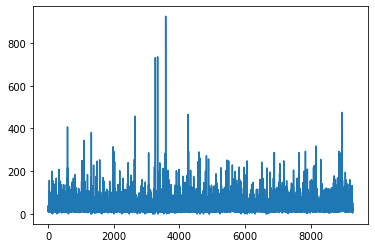

In [39]:
plt.plot(sen_len)
plt.show()

In [40]:
np.median(sen_len)

27.0

In [41]:
vals,counts = np.unique(sen_len, return_counts=True)
index = np.argmax(counts)
vals[index]

13

In [80]:
## Word to Vec model
w2v_model=Word2Vec(list_of_sentance,min_count=5,vector_size=50, workers=4)

In [81]:
w2v_words = list(w2v_model.wv.key_to_index.keys())

In [82]:
def len_equilize(lis_of_sent, length = 110):
    fin_eq_sents = []
    sent_cut = 0
    sent_padded = 0
    for sent in lis_of_sent:
        eq_sent = []
        if len(sent)>=length:
            if len(sent)>length:
                sent_cut+=1
            for i in range(length):
                if sent[i] in w2v_words:
                    vec = w2v_model.wv[sent[i]]
                else:
                    vec = np.zeros(50)
                eq_sent.append(vec)
        else:
            sent_padded+=1
            for i in range(len(sent)):
                if sent[i] in w2v_words:
                    vec = w2v_model.wv[sent[i]]
                else:
                    vec = np.zeros(50)
                eq_sent.append(vec)
            for i in range(len(sent), length):
                eq_sent.append(np.zeros(50))
        fin_eq_sents.append(eq_sent)
    return np.array(fin_eq_sents), sent_cut, sent_padded

In [83]:
fin_eq_sents, sent_cut, sent_padded = len_equilize(list_of_sentance)

In [94]:
final_input=[]
for sent in fin_eq_sents:
    temp = []
    for i in range(len(sent)):
        avg=np.sum(sent[i])/50
        temp.append(avg)
    final_input.append(temp)
final_input = np.array(final_input)

In [96]:
final_input.shape

(9286, 110)

In [100]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(final_input, labels, test_size=0.25)

In [101]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(6964, 110) (2322, 110) (6964,) (2322,)


In [102]:
RANDOM_STATE = 10

In [103]:
from sklearn.svm import SVC
svc = SVC(kernel='rbf', C=1.0, random_state=RANDOM_STATE)

In [104]:
svc.fit(X_train, y_train)

SVC(random_state=10)

In [106]:
svc.score(X_test, y_test)

0.7605512489233419

In [ ]:
from 